![dask.png](dask.png)

### Dask installation:
`` pip install "dask[complete]" pyarrow s3fs graphviz``

In [1]:
import dask

import dask.dataframe as dd

from dask.distributed import LocalCluster, Client

import pandas as pd

import numpy as np
import dask.array as da

import time
import os

### Dask Collections

* **High-level collections**: Mimic NumPy, lists, and pandas but can operate in parallel on datasets that don’t fit into memory 
    * Array
    * DataFrame
    * Bag
    
* **Low-level collections**: Give finer control to build custom parallel and distributed computations
    * Delayed
    * Futures



# Dask Dataframes

![dataframe.png](dataframe.png)

* One Dask DataFrame is comprised of many in-memory pandas DataFrames separated along the index. 
* One operation on a Dask DataFrame triggers many pandas operations on the constituent pandas DataFrames 
* These operations are mindful of potential parallelism and memory constraints.

In [2]:
!ls data/nycflights/*.csv

data/nycflights/1990.csv  data/nycflights/1994.csv  data/nycflights/1998.csv
data/nycflights/1991.csv  data/nycflights/1995.csv  data/nycflights/1999.csv
data/nycflights/1992.csv  data/nycflights/1996.csv
data/nycflights/1993.csv  data/nycflights/1997.csv


In [3]:
# Read all the csv file into a single Dask dataframe
ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"), parse_dates={"Date": [0, 1, 2]}
)

* dask.dataframe.read_csv only reads in a sample from the beginning of the file
* These inferred datatypes are then enforced when reading all partitions
* Sometimes, datatypes inferred in the sample can be incorrect. 
    * The first n rows have no value for CRSElapsedTime (which pandas infers as a float), and later on turn out to be strings (object dtype). 

* Good practice - specify dtypes directly using the dtype keyword. 

In [4]:
ddf = dd.read_csv(
    os.path.join("data", "nycflights", "*.csv"),
    parse_dates={"Date": [0, 1, 2]},
    dtype={"TailNum": str, "CRSElapsedTime": float, "Cancelled": bool},
)


In [5]:
ddf

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Lazy evaluation
* Representation of the DataFrame object contains no data 
* Dask has just done enough to read the start of the first file, and infer the column names and dtypes

* Dask **constructs** the logic (called task graph) of your computation immediately
* **Evaluates** them only when necessary

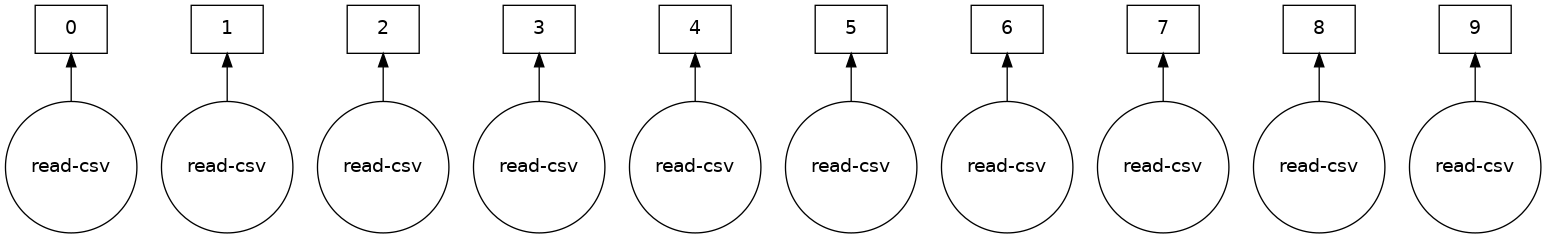

In [6]:

ddf.visualize()

* Functions like len, head, tail also trigger an evaluation.
    * load actual data, (that is, load each file into a pandas DataFrame)
    * apply the corresponding functions to each pandas DataFrame (also known as a partition)
    * combine the subtotals to give you the final grand total

In [7]:
len(ddf)

2611892

In [21]:
ddf.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


### Operation on multiple files in Pandas

In [23]:
# find the max value of the DepDelay coulmn in all the 10 dataframes
%%time
files = os.listdir(os.path.join('data', 'nycflights'))
maxes = []

for file in files:
    df = pd.read_csv(os.path.join('data', 'nycflights', file))
    maxes.append(df.DepDelay.max())

final_max = max(maxes)
print(final_max)

CPU times: user 5.46 s, sys: 1.39 s, total: 6.85 s
Wall time: 7 s


### Operation on multiple files in Dask

In [26]:
# find the max value of the DepDelay coulmn in all the 10 dataframes


# This only creates the task graph, it does not execute the operation
result = ddf.DepDelay.max()

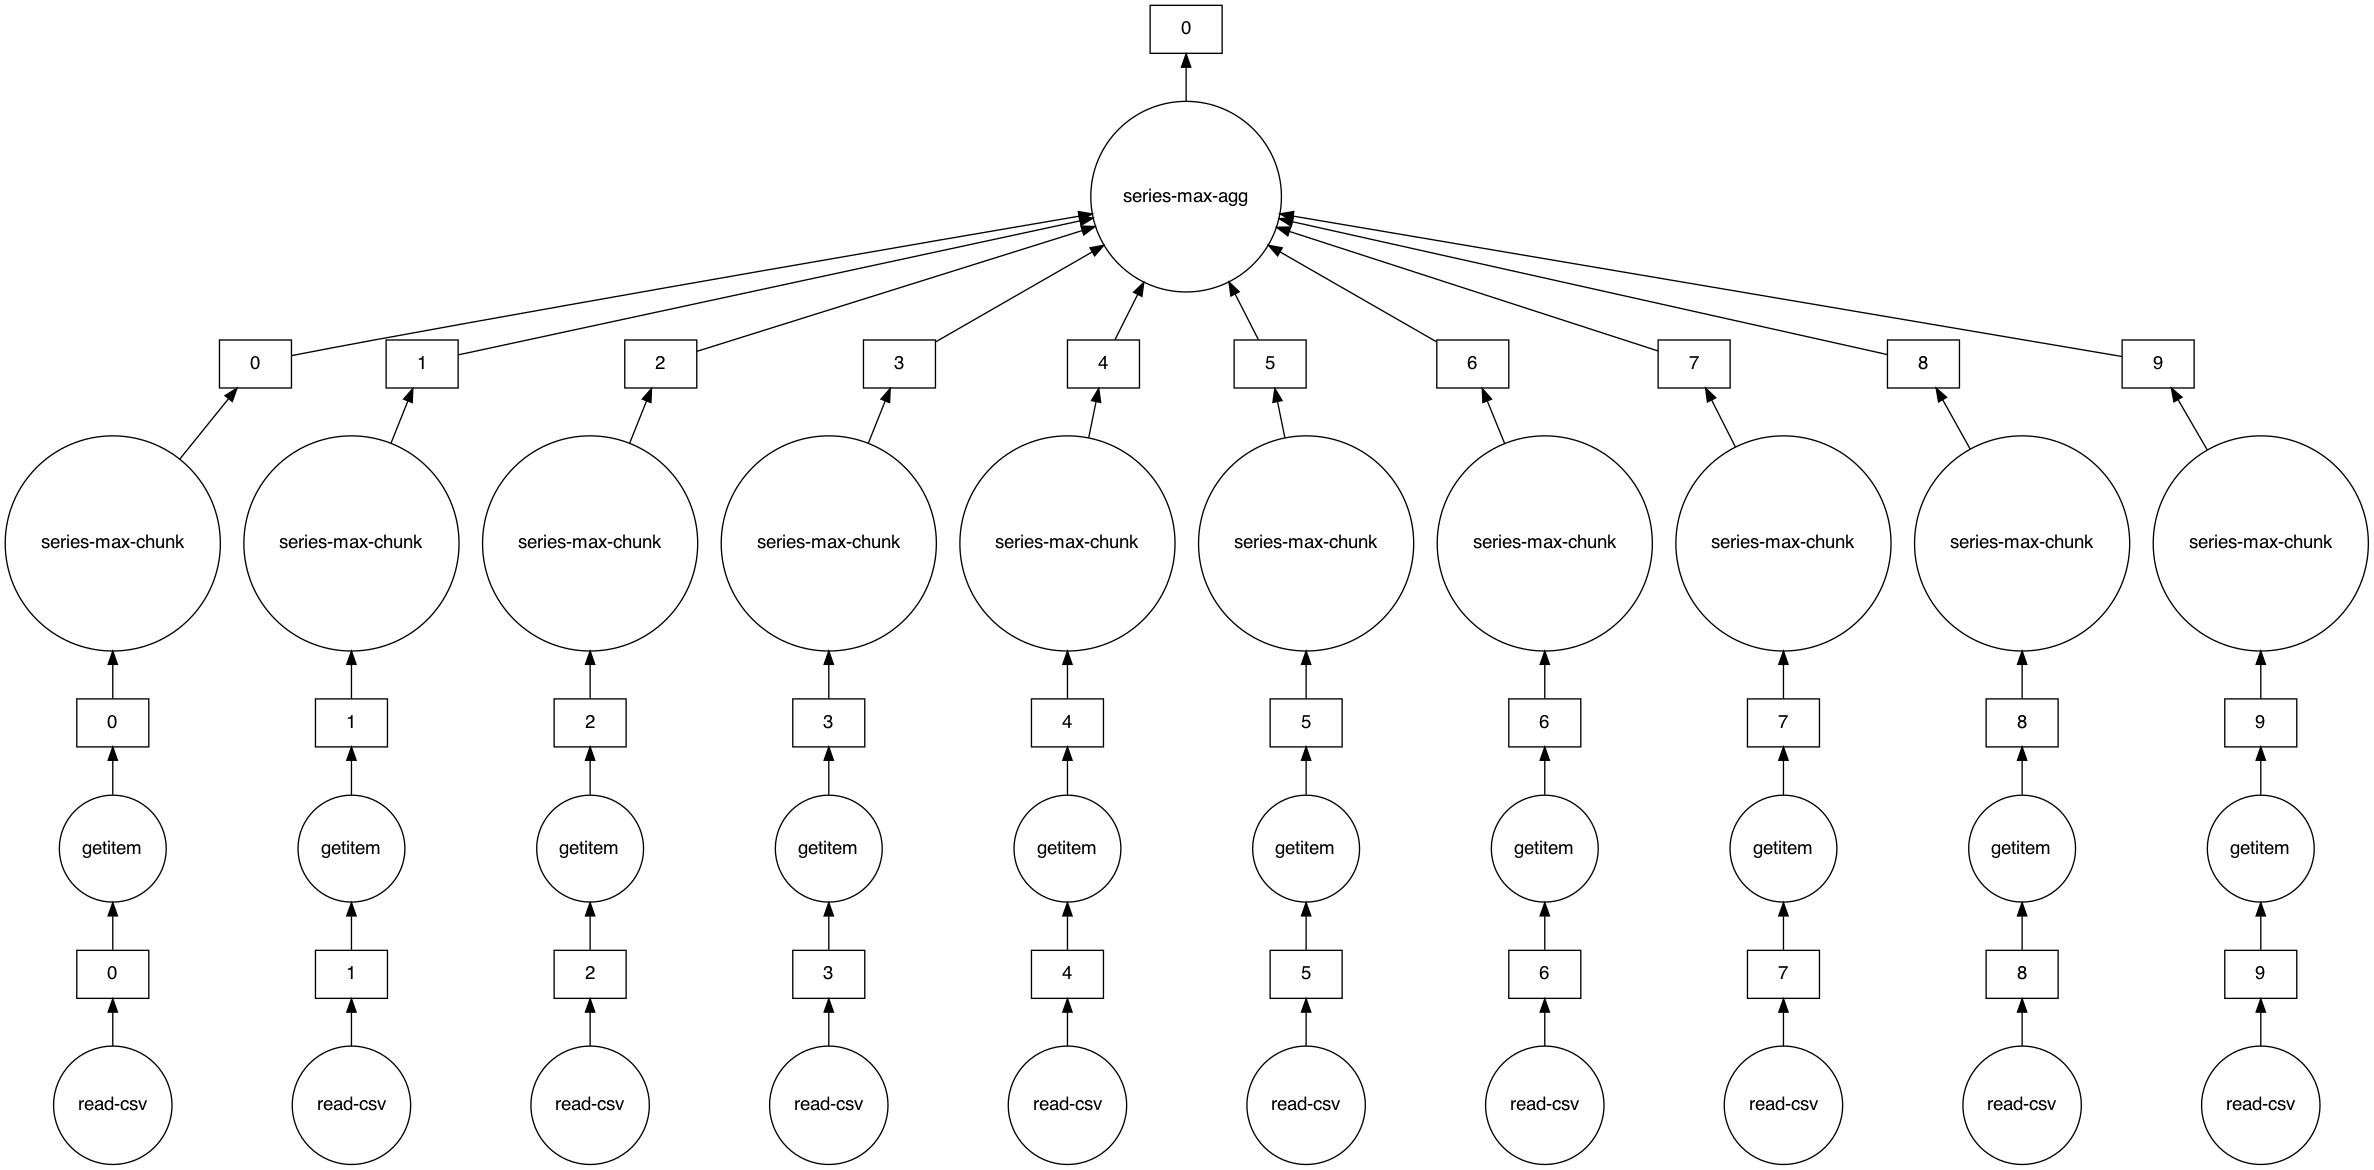

In [27]:
result.visualize()

In [28]:
%%time
result.compute()

CPU times: user 8.33 s, sys: 2.15 s, total: 10.5 s
Wall time: 5.52 s


1435.0

### Excercise: Find the number of flight from each city

* We can also combine multiple compute steps into a single instruction
* This is usualy more efficient
    * Task graphs for both results are merged when calling dask.compute
    * shared operations to only be done once instead of twice

In [36]:
non_canceled = ddf[~ddf.Cancelled]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [37]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 17.6 s, sys: 4.39 s, total: 22 s
Wall time: 12.1 s


In [38]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 8.45 s, sys: 2.04 s, total: 10.5 s
Wall time: 5.42 s


# Dask  Arrays - parallelized numpy

![arrays.png](arrays.png)

* Dask Array implements a subset of the NumPy ndarray interface using **blocked** algorithms
* Large array is cut into many small arrays
* Large computations are performed by combining many smaller computations

In [40]:

# NumPy array
a_np = np.ones(10)
a_np

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
# This is how a blocked operation is done in numpy. We divide the whole ndarray
# of size 10 int slices of 2, each of size 5

a_np_sum = a_np[:5].sum() + a_np[5:].sum()
a_np_sum

10.0

In [44]:
# Dask array

# In task ndarray we specify the slices usinh the keyword chunk. 
# chunk defines the numer of elements in each slice

a_da = da.ones(10, chunks=5)
a_da

dask.array<ones_like, shape=(10,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [45]:
a_da_sum = a_da.sum()
a_da_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

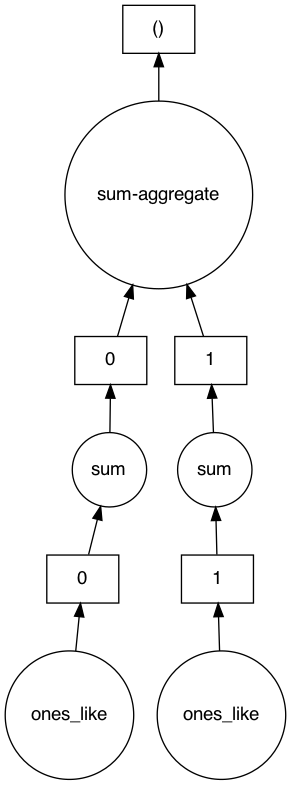

In [46]:
a_da_sum.visualize()

In [47]:
a_da_sum.compute()

10.0

* Dask can also find an optimal chunk by itself
* If your chunks are too small
    * the amount of actual work done by every task is very tiny
    * the overhead of coordinating all these tasks results in a very inefficient process
* If your chunks are too big
    * you will likely run out of memory
    * data will have to be moved to the disk 
    * this will lead to performance decrements

In [59]:
%%time

xd = da.random.normal(10, 0.1, size=(30_000, 30_000), chunks=(3000, 3000)) # We specify the chunk
yd = xd.mean(axis=0)
yd.compute()

CPU times: user 45.2 s, sys: 773 ms, total: 45.9 s
Wall time: 13.4 s


array([10.00036555, 10.00039709,  9.99985849, ...,  9.99973385,
        9.99979249, 10.00042994])

In [57]:
%%time

xd = da.random.normal(10, 0.1, size=(30_000, 30_000)) # Dask finds the chunk
yd = xd.mean(axis=0)
yd.compute()

CPU times: user 46.3 s, sys: 884 ms, total: 47.2 s
Wall time: 12.6 s


array([ 9.99992772,  9.99947219, 10.00004585, ...,  9.99993959,
       10.00027917,  9.99960698])

In [58]:
xd.chunksize

(4096, 4096)

# Delayed decorator

* A Block of code can have operations that can happen in parallel
* Normally in python these operation will happen sequentially
    * Or the user will identify the parallel section and write parallel codes
* The Dask **delayed** function decorates your functions so that they operate lazily 
* Dask will defer execution of the function, placing the function and its arguments into a task graph
* Dask will then identify oppurtunities for parallelism in the task graph
* The Dask schedulers will exploit this parallelism, generally improving performance

In [68]:
@dask.delayed
def inc(x):
    time.sleep(1)
    return x + 1




In [69]:
@dask.delayed
def add(x, y):
    time.sleep(1)
    return x + y

In [70]:
# As the two increments are independent of each other, we can run them in parallel

x = inc(1)
y = inc(2)
z = add(x, y)

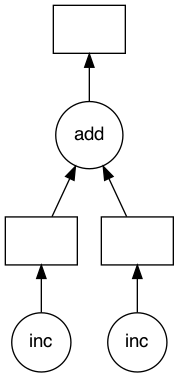

In [71]:
# Here Z is a delayed object

z.visualize()

In [72]:
z.compute()

5

# Dask future

* we can submit individual functions for evaluation
* The call returns immediately, giving one or more future
    * whose status begins as “pending”
    * later becomes “finished”
* There is no **blocking** of the local Python session.

* Difference between futures and delayed
    * delayed is lazy (it just constructs a graph) 
    * futures are eager. 
    * With futures, as soon as the inputs are available and there is compute available, the computation starts

In [80]:
client = Client(n_workers=4)

def inc(x):
    time.sleep(1)
    return x + 1


def double(x):
    sleep(2)
    return 2 * x


def add(x, y):
    time.sleep(1)
    return x + y

/usr/local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61150 instead
  warnings.warn(


In [81]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: pending, key: inc-5d503bfbb5ce36ccdd916d599c83f7a3>

#### If we check the future after a few seconds we can see that it is complete

In [82]:
future

<Future: finished, type: int, key: inc-5d503bfbb5ce36ccdd916d599c83f7a3>

In [83]:

future.result()

2

In [84]:
client.close()

# Distributed Dask 

![dask_cluster.png](dask_cluster.png)

* Dask can work on a clusteer
* We have been using the distributed scheduler for our work, but just on a single machine.
* When we instantiate a Client() object with no arguments it will attempt to locate a Dask cluster
    * It will check your local Dask config and environment variables to see if connection information has been specified
    * If not it will create an instance of LocalCluster and use that

In [87]:
cluster = LocalCluster()
cluster

/usr/local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 61250 instead
  warnings.warn(


LocalCluster(73340591, 'tcp://127.0.0.1:61251', workers=4, threads=4, memory=8.00 GiB)

In [88]:
cluster.get_logs()

{'Cluster': '',
 'Scheduler': "2023-05-25 17:38:05,991 - distributed.scheduler - INFO - State start\n2023-05-25 17:38:05,995 - distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:61251\n2023-05-25 17:38:05,995 - distributed.scheduler - INFO -   dashboard at:           127.0.0.1:61250\n2023-05-25 17:38:08,823 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:61262', name: 0, status: running, memory: 0, processing: 0>\n2023-05-25 17:38:08,827 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61262\n2023-05-25 17:38:08,828 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:61263', name: 3, status: running, memory: 0, processing: 0>\n2023-05-25 17:38:08,829 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61263\n2023-05-25 17:38:08,831 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:61264', name: 1, status: running, memory: 0, processing: 0>\n2023-05-25 17:38:08,833 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61264\n2023-05-25 17:38:08,835 - distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:61265', name: 2, status: running, memory: 0, processing: 0>\n2023-05-25 17:38:08,837 - distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:61265",
 'tcp://127.0.0.1:61262': '2023-05-25 17:38:07,692 - distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:61262\n2023-05-25 17:38:07,692 - distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:61262\n2023-05-25 17:38:07,692 - distributed.worker - INFO -           Worker name:                          0\n2023-05-25 17:38:07,692 - distributed.worker - INFO -          dashboard at:            127.0.0.1:61267\n2023-05-25 17:38:07,692 - distributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:61251\n2023-05-25 17:38:07,692 - distributed.worker - INFO - -------------------------------------------------\n2023-05-25 17:38:07,692 - distributed.worker - INFO -               Threads:                          1\n2023-05-25 17:38:07,692 - distributed.worker - INFO -                Memory:                   2.00 GiB\n2023-05-25 17:38:07,692 - distributed.worker - INFO -       Local Directory: /var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/dask-worker-space/worker-bwo0fh8l\n2023-05-25 17:38:07,692 - distributed.worker - INFO - -------------------------------------------------\n2023-05-25 17:38:08,827 - distributed.worker - INFO -         Registered to:      tcp://127.0.0.1:61251\n2023-05-25 17:38:08,828 - distributed.worker - INFO - -------------------------------------------------',
 'tcp://127.0.0.1:61263': '2023-05-25 17:38:07,692 - distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:61263\n2023-05-25 17:38:07,692 - distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:61263\n2023-05-25 17:38:07,692 - distributed.worker - INFO -           Worker name:                          3\n2023-05-25 17:38:07,692 - distributed.worker - INFO -          dashboard at:            127.0.0.1:61266\n2023-05-25 17:38:07,692 - distributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:61251\n2023-05-25 17:38:07,692 - distributed.worker - INFO - -------------------------------------------------\n2023-05-25 17:38:07,692 - distributed.worker - INFO -               Threads:                          1\n2023-05-25 17:38:07,692 - distributed.worker - INFO -                Memory:                   2.00 GiB\n2023-05-25 17:38:07,692 - distributed.worker - INFO -       Local Directory: /var/folders/xy/sdhcdzdd7m1b5v3m19jf8f940000gn/T/dask-worker-space/worker-8fexc70w\n2023-05-25 17:38:07,692 - distributed.worker - INFO - -------------------------------------------------\n2023-05-25 17:38:08,830 - distributed.worker - INFO -         Registered to:      tcp://127.0.0.1:61251\n2023-05-25 1

In [89]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:61250/status,
Dashboard: http://127.0.0.1:61250/status,Workers: 4
Total threads: 4,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61251,Workers: 4
Dashboard: http://127.0.0.1:61250/status,Total threads: 4
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:61262,Total threads: 1
Dashboard: http://127.0.0.1:61267/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:61254,


In [90]:

del client, cluster

Useful links:
1. [Distributed Dask](https://tutorial.dask.org/04_distributed.html)
2. [Dask-ML](https://ml.dask.org/)
3. [Dask-cuDF](https://docs.rapids.ai/api/cudf/stable/user_guide/10min/)